In [1]:
# importar las librerias que vamos a usar
import numpy as np
import matplotlib.pyplot as plt

Paso 1: Encontrar xf y zf del hipocentro de un sismo a partir de tiempo de viaje entre fuente y receptor.

El hipocentro esta entre xf = [-10, 10] km y zf = [12, 8] km.

Paso 2: N datos = 2, M parametros = 2, K = 1 limites de busqueda
La ecuación que vincula modelo y datos g(m) = d

In [2]:
# Definimos la funcion 
# d = g(m)
# d = distancia_fuente-receptor / velocidad_de_propagación

# Cálculo del tiempo de viaje "traveltime"
def tiempo_de_viaje(xf, zf, xr, zr, vel):
    # estimación de tiempo de viaje a cada receptor
    distancia = np.sqrt((xf - xr)**2. + (zf - zr)**2.)
    tiempo = distancia / vel
    return tiempo

Paso 3: Solución de prueba iteración 1

In [ ]:
# Definimos m^k  de k=1 primera iteración  
m_k = np.asarray([1, 11])

Paso 4: ingredientes: 1) Gradiente, 2) residuales (t_obs - t_cal) = delta_d, delta_m el paso de actualización del modelo

In [6]:
# Estimacion de las derivadas parciales, gradiente, frechet derivatives
def gradiente_tiempo_de_viaje(xf, zf, xr, zr, vel, delta):

    # Cálculo de derivadas parciales
    grad = np.zeros((len(xr), 2), dtype=float)
 
    # para cada renglon de la matriz
    for i in range(len(xr)):
        # calculo en xf, zf
        t_c = tiempo_de_viaje(xf, zf, xr[i], zr[i], vel)
        
        # con respecto a X
        t_delta_x = tiempo_de_viaje(xf+delta, zf, xr[i], zr[i], vel)
        #print(t_delta_x, t_c)
        derivada_x = (t_delta_x - t_c) / delta
        # con respecto a Z
        t_delta_z = tiempo_de_viaje(xf, zf+delta, xr[i], zr[i], vel)
        #print(t_delta_z, t_c)
        derivada_z = (t_delta_z - t_c) / delta

        # colocar en la matriz G, osea matriz del gradiente
        grad[i][0] = derivada_x
        grad[i][1] = derivada_z

    return grad

# Estimación del ajuste de los datos 
def delta_d(t_obs, t_cal):
    del_d = np.zeros((len(t_cal), 1), dtype=float)
    for i in range(len(t_cal)):
        del_d[i] = t_obs[i] - t_cal[i]
    return del_d

# Estimación del ajuste de los datos Norma L2
def ajuste_norma_l2(t_obs, t_cal):
    delta_time = []
    for i in range(len(t_obs)):
        delta_time.append(t_obs[i] - t_cal[i])
    delta_time = np.asarray(delta_time)
    ajuste = (1/2) * (np.matmul(delta_time.T, delta_time))
    return ajuste

Paso 6: Actualizar el modelo iterando con las ecuaciones

In [32]:
# Delta para el calculo de las derivadas parciales
delta_dist = 0.1  # km

# Definimos velocidad del medio
vel = 5   #km/s

# Posici'on de los receptores
xr = [0, 1]
zr = [0, 0]

# tiempos de viaje observados a los receptores
t_obs = [2.0, 2.009975124224178]

# Solucione inicial, iteracion 1
#                  xf, zf
m_k = np.asarray([1, 20])  #km
# vector columna
m_k = m_k.T
print(m_k,'k=',0)
costo = []    # lista del ajuste por iteracion
m_i = []      # lista de modelos visitados
c = 1         # primer ajuste
k = 0         # prieera iteracion
tolerancia = 0.00005 # que tan lejos del minimo podemos aceptar
# ciclo de mejora del modelo
while c > tolerancia:       # mientras el desajuste es grande
    # Calcula G
    grad_k = gradiente_tiempo_de_viaje(m_k[0], m_k[1], xr, zr, vel, delta_dist)
    # Calcula delta d
    t_cal = np.zeros((len(xr), 1), dtype=float)
    for i in range(len(xr)):
        t_cal[i] = tiempo_de_viaje(m_k[0], m_k[1], xr[i], zr[i], vel)
    del_d = delta_d(t_obs, t_cal)

    # epsilon
    epsilon = 0  # peso del amortiguamiento
    I = np.eye(2)    # matriz identidad
    
    # Calcula delta m
    GTG = np.matmul(grad_k.T, grad_k)
    e2I = epsilon**2.*I
    GTGe2I = GTG + e2I
    GTGe2Iinv = np.linalg.inv(GTGe2I)
    GTd = np.matmul(grad_k.T, del_d)
    del_m = np.matmul(GTGe2Iinv, GTd)
    
    # calculo del ajuste en la iteracion k
    c = ajuste_norma_l2(t_obs, t_cal)
     
    # Guardamos información de cada iteración
    costo.append(c[0])
    m_i.append(np.copy(m_k))

    # Monitoreamos la evolución en cada iteración
    print(m_k, 'k = ', k, 'ajuste = ', c)

    # Actualizamos el modelo al siguiente paso
    #         xf + delta xf
    m_k[0] = m_k[0] + del_m[0]
    #         zf + delta zf
    m_k[1] = m_k[1] + del_m[1]
    k += 1    # siguiente iteracion

[ 1 20] k= 0
[ 1 20] k =  0 ajuste =  [[3.99010575]]
[ 0 10] k =  1 ajuste =  [[0.]]


/tmp/ipykernel_7660/602188193.py:16: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(m_i[s_i][0], m_i[s_i][1], 80, marker='x', color='red', edgecolor='black')


[ 1 20]
[ 0 10]


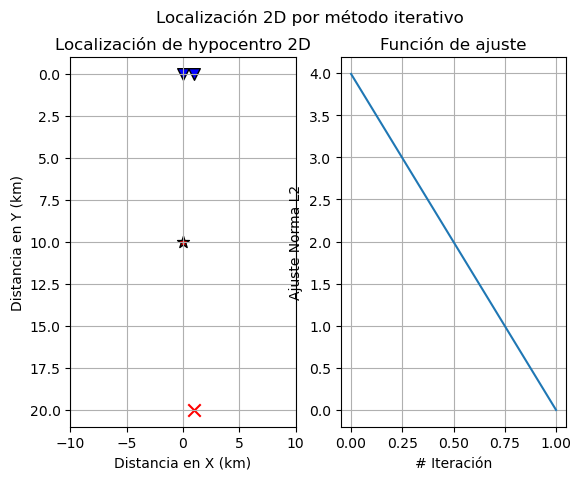

In [33]:
# Grafiquemos los resultados
fig2 = plt.figure(2)

fig2.suptitle('Localización 2D por método iterativo')

ax1 = fig2.add_subplot(1,2,1)
ax1.set_title('Localización de hypocentro 2D')
ax1.set_xlabel('Distancia en X (km)')
ax1.set_ylabel('Distancia en Y (km)')
# Graficando receptores
for r_i in range(len(xr)):
    ax1.scatter(xr[r_i], zr[r_i], 70, marker='v', color='blue', edgecolor='black')
# Graficando el historico de las localizaciones
for s_i in range(len(costo)):
    if s_i < len(costo)-1:
        ax1.scatter(m_i[s_i][0], m_i[s_i][1], 80, marker='x', color='red', edgecolor='black')
        print(m_i[s_i])
    else:
        ax1.scatter(m_i[s_i][0], m_i[s_i][1], 80, marker='*', color='red', edgecolor='black')
        print(m_i[s_i])

# Labels
ax1.grid()
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_xlim([-10,10])

# Graficando el histórico del ajuste
ax2 = fig2.add_subplot(1,2,2)
ax2.set_title('Función de ajuste')
iteracion = np.linspace(0, len(m_i)-1, len(m_i))
ax2.plot(iteracion, costo)
# labels
ax2.set_xlabel('# Iteración')
ax2.set_ylabel('Ajuste Norma L2')
ax2.grid()

In [14]:
print(costo)

[array([9.27055623]), array([9.95031033e-05]), array([0.])]
